# Stohastički sistemi i Estimacija: Domaći zadatak 2

### Učitavanje osnovnih biblioteka

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal
from scipy.stats import norm

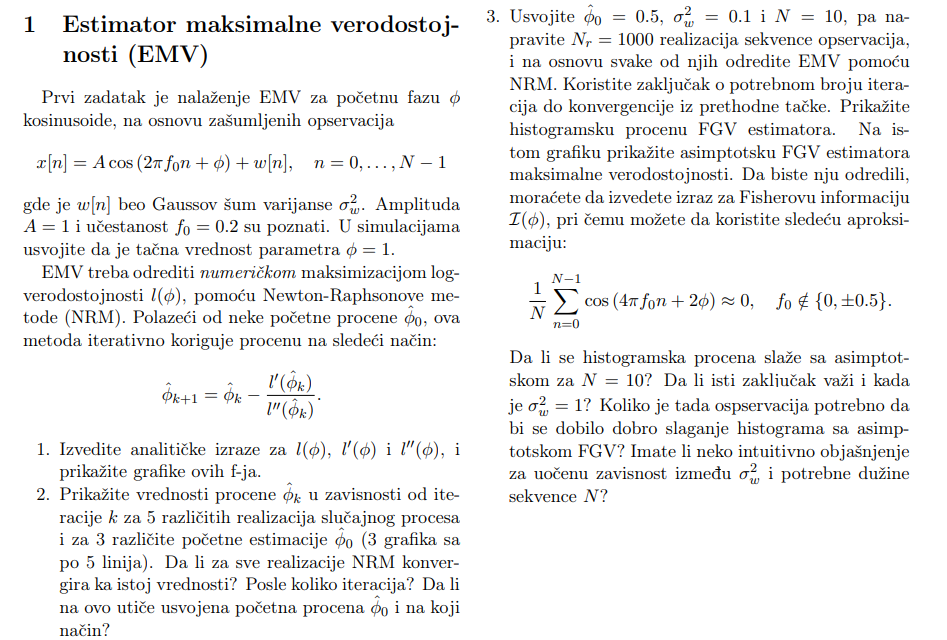

In [9]:
# Zadati parametri
phi   = 1
f     = 0.2
A     = 1
sigma = 0.5
K     = 2*np.pi*f
N     = 100

### 1. Analitički izrazi za $l(\phi)$, $l'(\phi)$, $l''(\phi)$ su:
$$ 
l(\phi) = - \frac{1}{2\sigma^2} \sum^{N-1}_{n=0}
[x[n] - Acos(2\phi f_0n + \phi)]^2
$$

$$
l'(\phi) = - \frac{A}{\sigma^2} \sum^{N-1}_{n=0}[x[n]sin(2\pi f_0 n + \phi) - \frac{A}{2}sin(4\phi f_0 n + 2\phi)]
$$

$$
l''(\phi) = - \frac{A}{\sigma^2} \sum^{N-1}_{n=0}[x[n]cos(2\pi f_0 n + \phi) - A cos(4\phi f_0 n + 2\phi)]
$$

### Imlementacija gore navedenih funkcija

In [10]:
def l(X, phi):
    """
    log-likelihood function of vector X over parameter phi
    """

    N, = np.shape(X)
    return -1/(2*sigma**2) * np.sum(np.power(X - np.cos(K*np.arange(N, dtype=float) + phi), 2))

In [11]:
def l_prim(X, phi):
    """
    first derivative of log-likelihood function 
    of vector X over parameter phi
    """

    N, = np.shape(X)
    X_ = X - np.cos(K*np.arange(N, dtype=float) + phi)
    return (-1/sigma**2) * X_ @ np.sin(K*np.arange(N, dtype=float) + phi)

In [12]:
def l_sec(X, phi):
    """
    second derivative of log-likelihood function 
    of vector X over parameter phi
    """

    N, = np.shape(X)
    n = np.arange(N, dtype=float)
    c = np.cos(K*n + phi)
    s = np.sin(K*n + phi)

    return (-1/sigma**2) * (s.T @ s + (X - c).T @ c)

### Grafici funkcija $l(\phi)$, $l'(\phi)$, $l''(\phi)$ za realizaciju slučajnog vektora $X$:

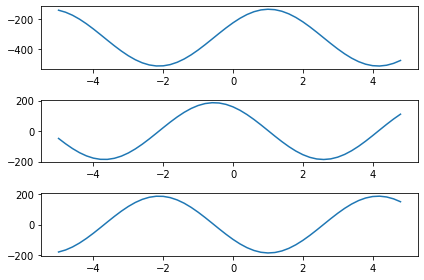

In [15]:
# Inicijalizacija signala i šuma
w = normal(0, np.sqrt(sigma), N)
X = A*np.cos(K*np.arange(N, dtype=float) + phi) + w

# Inicijalizacija niza vrednosti za fi
phi_arr = np.arange(-5, 5, 0.2)

# Računanje l, l' i l"
L       = [l(X, phi)        for phi in phi_arr]
L_prim  = [l_prim(X, phi)   for phi in phi_arr]
L_sec   = [l_sec(X, phi)    for phi in phi_arr]

# Plot
plt.subplot(311)
plt.plot(phi_arr, L)

plt.subplot(312)
plt.plot(phi_arr, L_prim)

plt.subplot(313)
plt.plot(phi_arr, L_sec)
plt.tight_layout()
plt.show()

### 2. Simulacija pronalaska $\hat{\phi}_k$ korišćenjem Newton-Raphsonove metode

In [16]:
def NewtRaph(X, phi_start):
    """
    Estimate parameter phi for observation vector X
    and start assumption phi_start
    """
    
    phi_est = [phi_start]

    for _ in range(15):
        phi_k   = phi_est[-1]
        step    = l_prim(X, phi_k) / l_sec(X, phi_k)

        phi_est.append(phi_k - step) 

    return phi_est

### Simulacija estimiranja parametra $\phi$ za početne vrednosti $\hat{\phi}_0 = \{0, 1, 2\}$

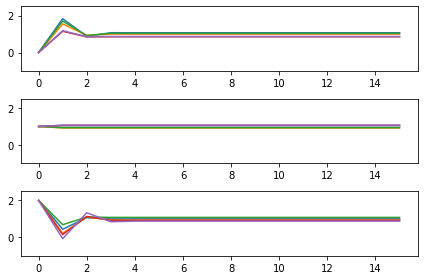

In [22]:
# Vektor početnih vrednosti
phi_starts = [0, 1, 2]

# Definisanje nezašumljenog kosinusnog signala
c = A*np.cos(K*np.arange(N, dtype=float) + phi)

# Estimiranje za sve parametre
for idx, phi_start in enumerate(phi_starts):
    
    # Definisanje subfigure
    plt.subplot(3, 1, idx + 1)
    plt.ylim(top=2.5)
    plt.ylim(bottom=-1)
    
    # Estimacija za 5 različitih realizacija šuma
    for _ in range(5):
        w   = normal(0, sigma, N)
        X   = c + w
        est = NewtRaph(X, phi_start)
        plt.plot(est)
        
plt.tight_layout()
plt.show()

### 3. Usvajamo nove početne parametre i na osnovu realizacija procenjujemo FGV estimatora

In [23]:
# Novi početni parametri
Nr = 1000
phi_0 = 0.5
s_w = 0.1
N = 10

#### Radi poređenja simulacije i teorije računamo Fisherovu informaciju:

$$ 
\mathcal{I}(\phi) = -E(l''(\phi)) = \frac{A}{\sigma^2}
\bigg[ \frac{1}{2} + \frac{1}{2}cos(4\phi f_0 n + 2\phi) - cos(4\phi f_0 n + 2\phi) \bigg] \approx \frac{NA^2}{2\sigma^2}
$$

In [24]:
# Definisanje teoretske FGV
FI  = np.sqrt((N*A/(2 * (s_w ** 2)))**(-1))

x   = np.linspace(.9, 1.1, 100)
fgv = norm.pdf(x, phi, FI)

#### Simulacija FGV za $N_r = 1000$ odbiraka

In [26]:
# Vektor estimacija
est = []

# Inicijalizacija nezašumljenog kosinusa
c = A*np.cos(K*np.arange(N, dtype=float) + phi)

# Simulacija estimacije fi nad zašumljenim observacijama Nr puta
for _ in range(Nr):
    w   = normal(0, s_w, N)
    X   = c + w
    est.append(NewtRaph(X, phi_0)[-1])

#### Poređenje eksperimenta i teorije

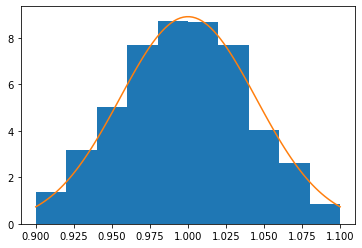

In [27]:
plt.hist(est, density=True, range=(.9, 1.1))
plt.plot(x, norm.pdf(x, phi, FI))
plt.show()

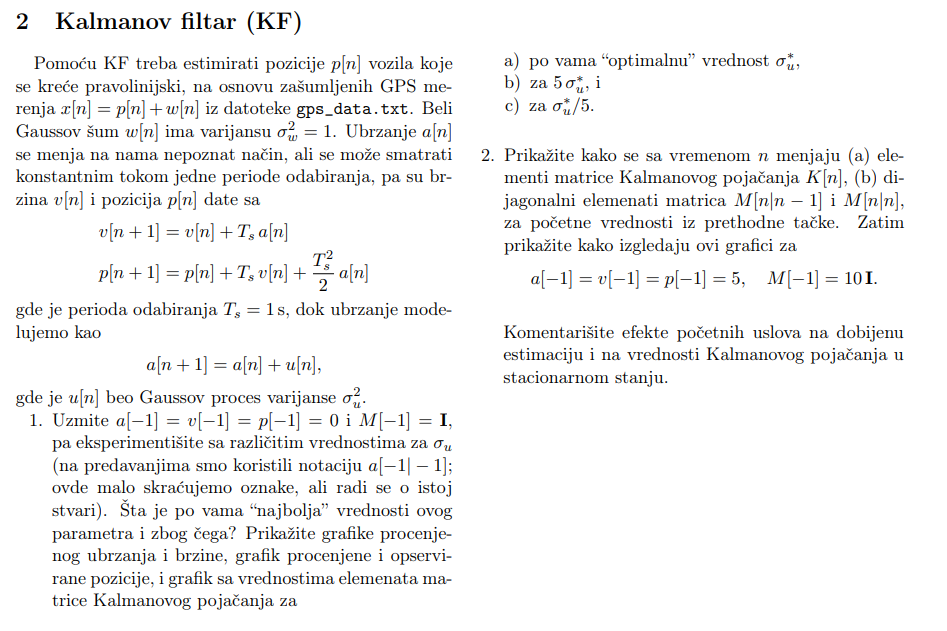

### Jednačine opisa fizike i ponašanja Kalmanovog filtera


In [28]:
# Vremenski korak
T = 1

# Definisanje sistema
A = np.array([
    [1, T, T**2/2],
    [0, 1, T],
    [0, 0, 1]
])

B = np.array([[T**2/2, T, 1]])

H = np.array([[1, 0, 0]])

### Implementacija simulacije Kalmanovog filtriranja zadatog signala

In [56]:
def simulateKalman(X, s0, M0, sigma_u, sigma_w):
    """
    Simulate output of Kalman filter for observations X,
    starting state s0, starting variance M0, and variances
    for control (sigma_u) and noice (sigma_w)
    """
    
    # Broj observacija
    N, _ = X.shape
    
    # Inicijalizacija vektora vektora stanja
    s    = np.zeros((N, 3, 1))
    s[0] = s0

    # Inicijalizacija vektora matrica varijansi
    M    = np.zeros((N, 3, 3))
    M[0] = M0

    # Inicijalizacija vektora vektora Kalmanovog pojačanja
    K = np.zeros((N, 3, 1))

    # Inicijalizacija matrica šuma
    Q = sigma_u**2
    C = sigma_w**2

    # Simulacija
    for n in range(1, N):
        
        # Predikcija
        s[n] = A @ s[n - 1]
        M[n] = A @ M[n - 1] @ A.T + B * Q @ B.T

        # Kalmanovo pojačanje
        K[n] = M[n] @ H.T / (C + H @ M[n] @ H.T)

        # Inovacija
        s[n] = s[n] + K[n] * (X[n] - H @ s[n])
        M[n] = M[n] - (K[n] @ H) @ M[n]

    return s, M, K

### 1. Filtriranje opservacija GPS podataka Kalmanovim filterom, pretpostavljeno $\sigma_u^* = 0.005$

In [76]:
plt.rcParams["figure.figsize"] = (20, 10)

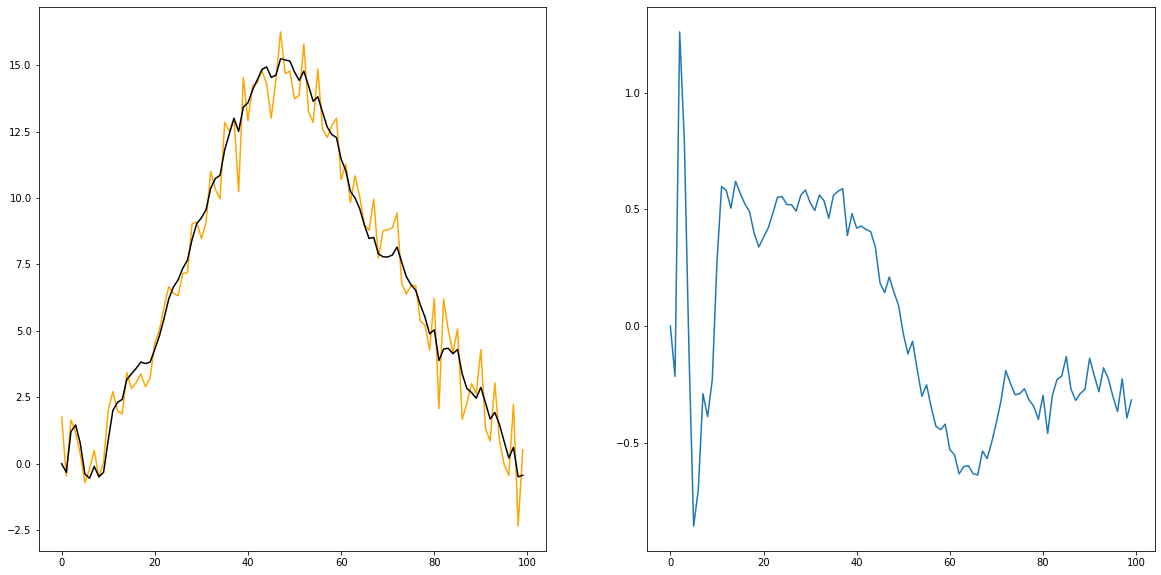

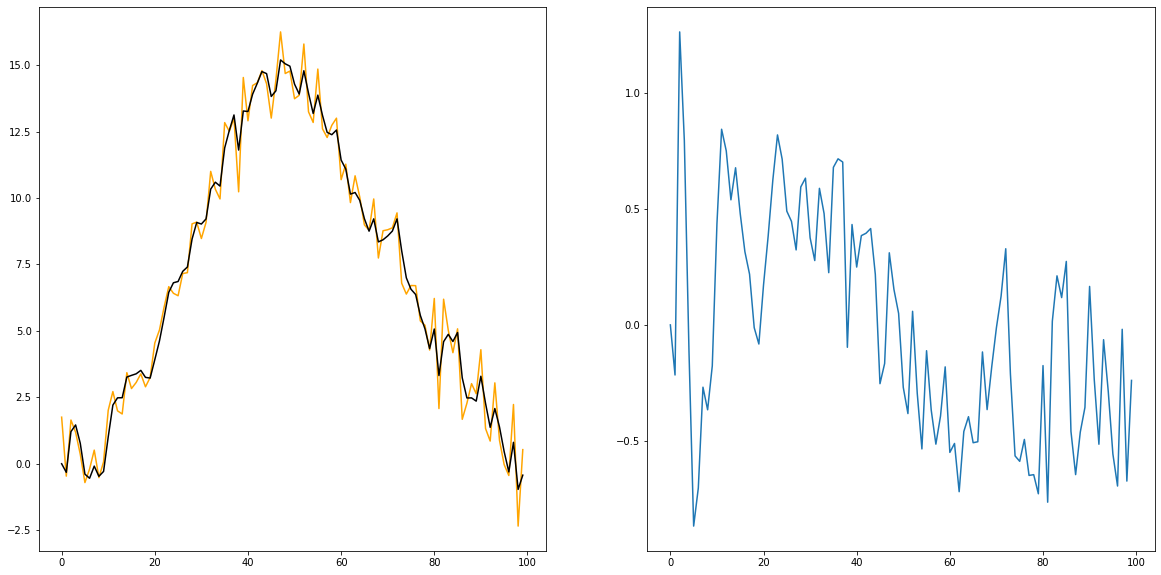

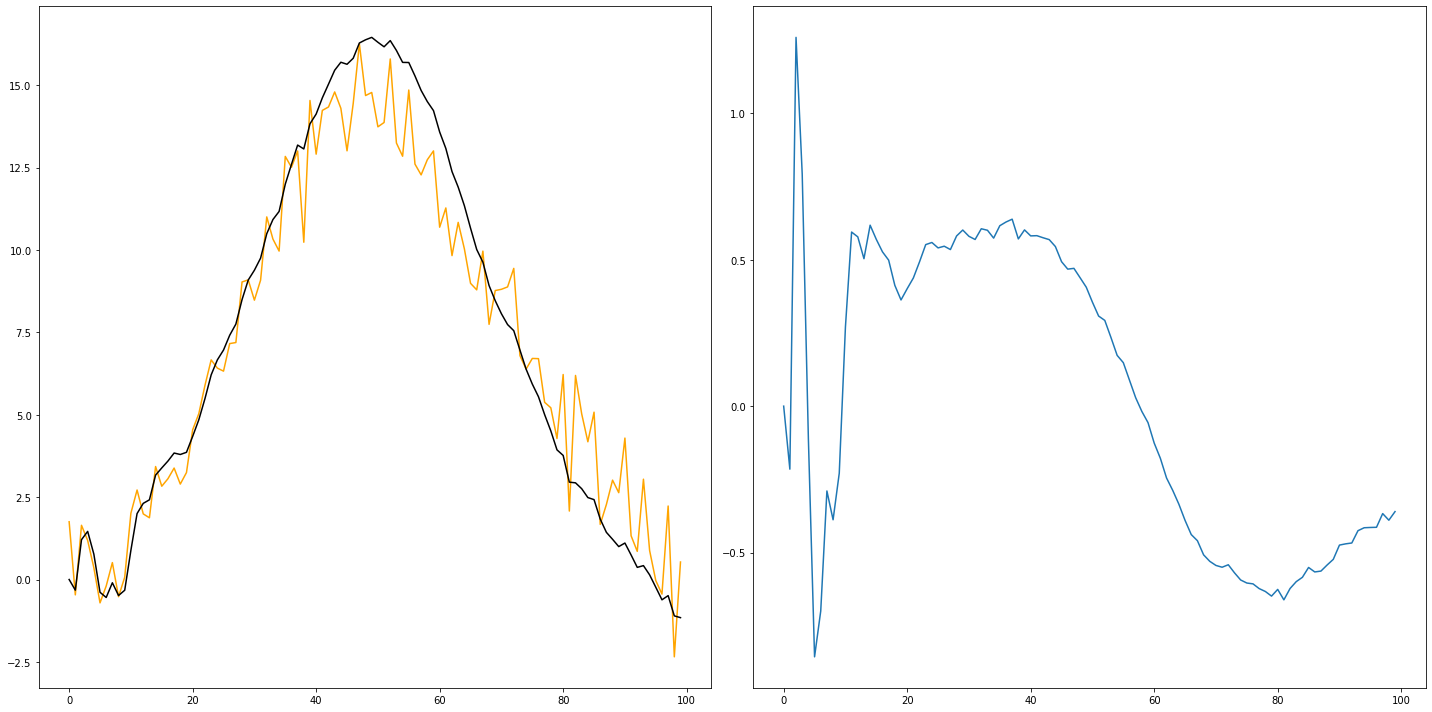

In [78]:
# Učitavanje podataka
X  = np.array([[float(x.strip()) for x in open('gps_data.txt').readlines()]]).T

# Definisanje početnih vrednosti
s0 = np.array([[0, 0, 0]]).T
M0 = np.eye(3)
sigma_w = 1

# Pretpostavljena najbolja standardna devijacija
s_u_best = 0.005

for idx, sigma_u in enumerate([s_u_best, 10*s_u_best, s_u_best/10]):

    # Filtriranje
    ss, M, K = simulateKalman(X, s0, M0, sigma_u, sigma_w)

    plt.figure()


    plt.subplot(1, 2, 1)
    plt.plot(X, 'orange')
    plt.plot(ss[:, 0], 'black')

    plt.subplot(1, 2, 2)
    plt.plot(ss[:, 1])

plt.tight_layout()
plt.show()

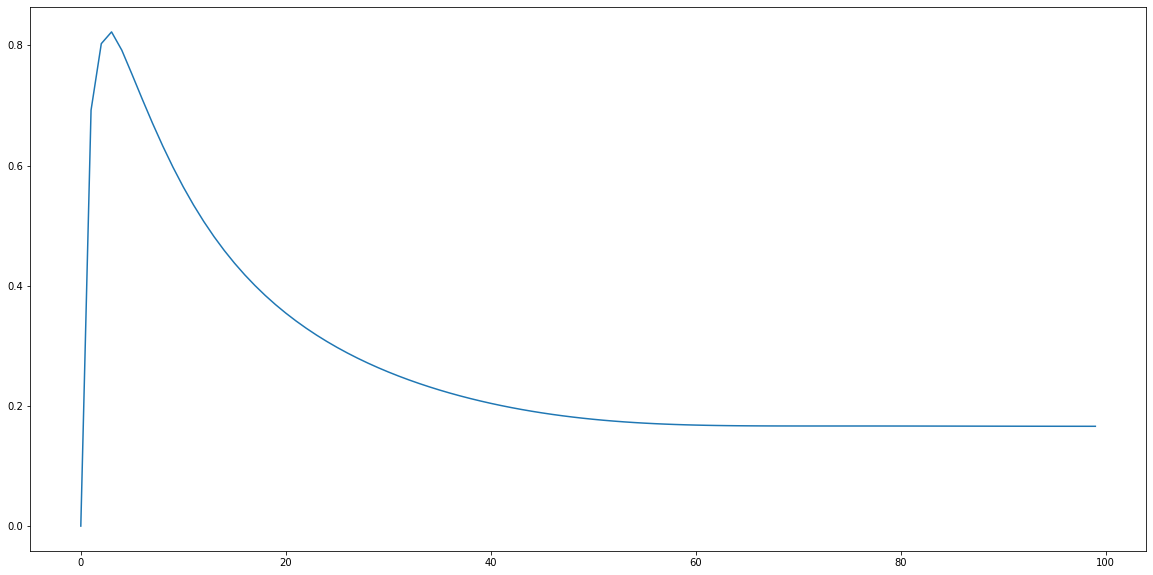

In [85]:
plt.plot(K[:, 0])